In [5]:
import json
import matplotlib.pyplot as plt
import os
import time
import logging
from datetime import datetime
from collections import defaultdict
import numpy as np
import torch
import argparse
import scanpy as sc

from fcr import FCR_sim
from fcr import fetch_latest
from fcr.evaluate.evaluate import evaluate, evaluate_classic, evaluate_prediction

## Load the model and datasets 

In [3]:
model_path = "/cluster/work/bewi/members/rquiles/experiments/error_screening/3_cell_2_drug_lr-/saves/error_screening_2025.10.09_12:31:18/model_seed=None_epoch=620.pt"
fcr_model = FCR_sim(model_path=model_path, dataset_mode="all")

trained_model = fcr_model.model
datasets = fcr_model.dataset
args = fcr_model.arguments

Performing automatic train-test split with 0.2 ratio.


## Load Representations

In [4]:
import numpy as np
from tqdm import tqdm

ZXs = []
ZTs = []
ZXTs = []
for data in tqdm(datasets["loader_tr"], desc="Processing batches"):
    (genes, perts, cf_genes, cf_perts, covariates) = (
            data[0], data[1], data[2], data[3], data[4:])

    ZX, ZXT, ZT = trained_model.get_latent_presentation(genes, perts, covariates, sample=False) # sigma1=2e-1, sigma2=5e-3, sigma3=1e-3)
    ZXs.extend(ZX)
    ZTs.extend(ZT)
    ZXTs.extend(ZXT)


Processing batches: 100%|██████████| 170/170 [00:46<00:00,  3.68it/s]


In [5]:
ZXs = [e.detach().cpu().numpy() for e in ZXs]
ZXs = np.array(ZXs)

ZXTs = [e.detach().cpu().numpy() for e in ZXTs]
ZXTs = np.array(ZXTs)

ZTs = [e.detach().cpu().numpy() for e in ZTs]
ZTs = np.array(ZTs)

## Load the RAW data to ADATA

In [7]:
import scanpy as sc
adata = sc.read(args["data_path"])


In [8]:
adata.obsm["ZXs"] = ZXs
adata.obsm["ZTs"] = ZTs
adata.obsm["ZXTs"] = ZXTs


## Plot before FCR

In [10]:
#sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

#PCA
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata, min_dist=0.3)

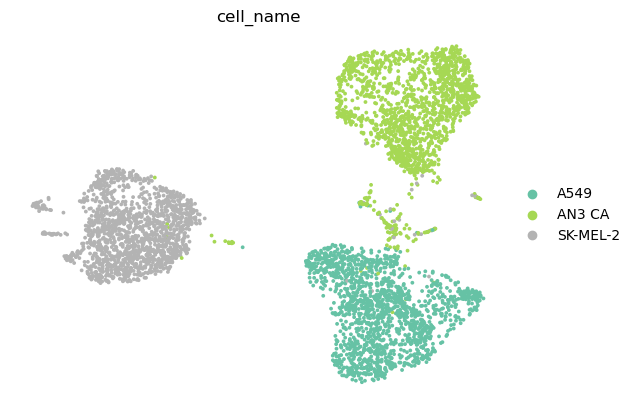

In [11]:
# UMAPs
sc.pl.umap(
    adata,
    color=["cell_name"],
    palette="Set2",
    frameon=False,
    size=30,
)

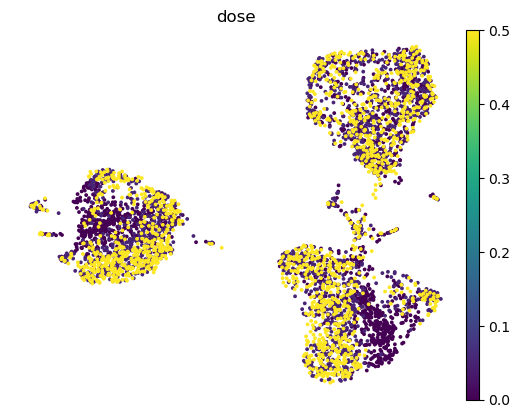

In [12]:
sc.pl.umap(
    adata,
    color=["dose"],
    palette="Set2",
    frameon=False,
    size=30,
)

## Try settings

--- UMAP setting 1: {'n_neighbors': 10, 'min_dist': 0.05, 'spread': 5.0, 'metric': 'cosine'} ---


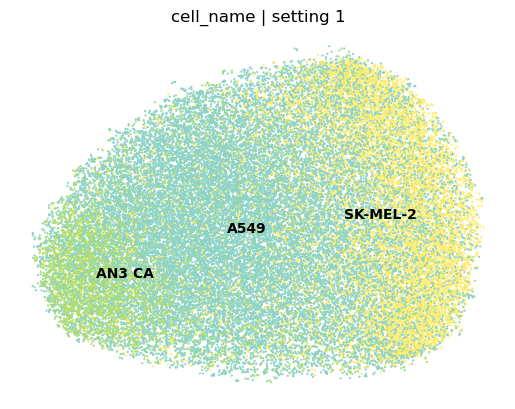

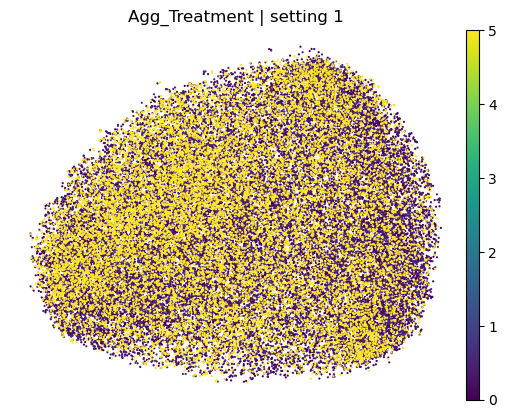

--- UMAP setting 2: {'n_neighbors': 10, 'min_dist': 0.05, 'spread': 5.0, 'metric': 'euclidean'} ---


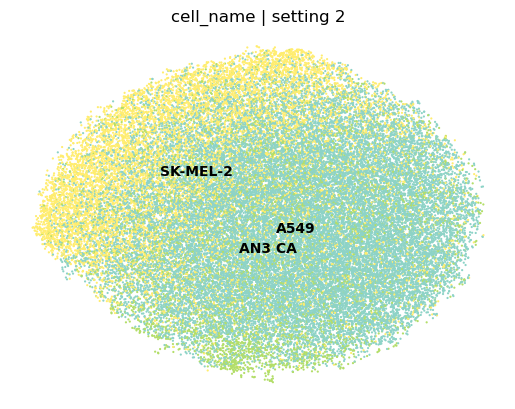

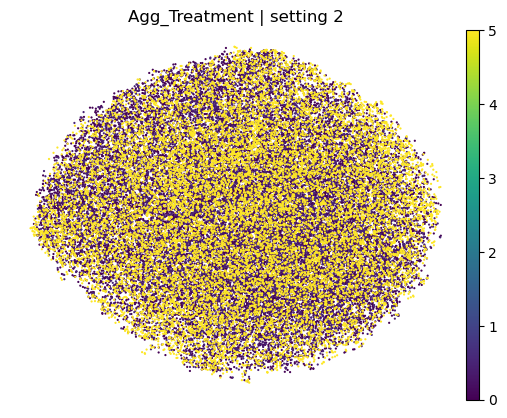

--- UMAP setting 3: {'n_neighbors': 10, 'min_dist': 0.05, 'spread': 3.0, 'metric': 'cosine'} ---


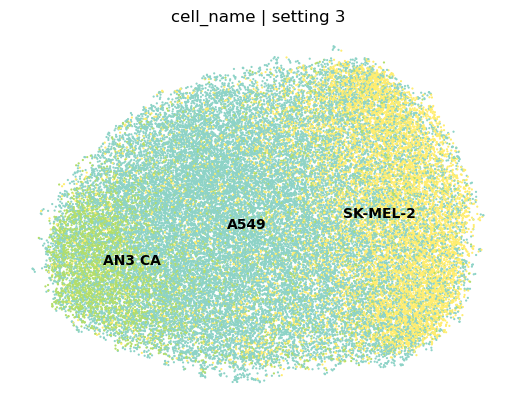

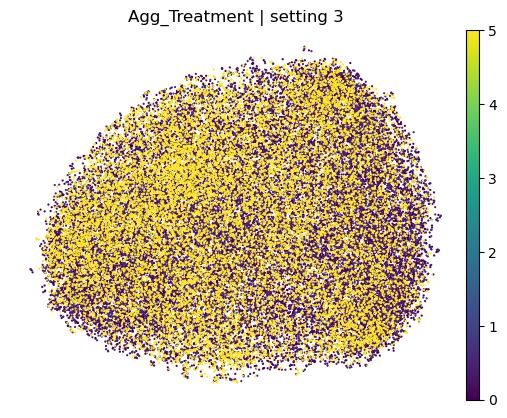

--- UMAP setting 4: {'n_neighbors': 10, 'min_dist': 0.05, 'spread': 3.0, 'metric': 'euclidean'} ---


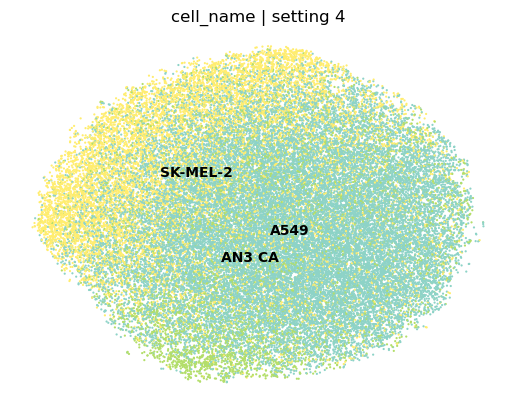

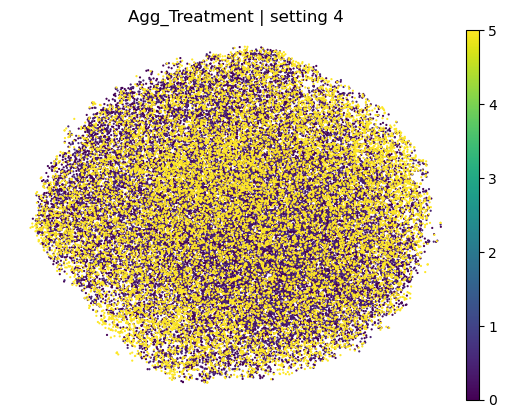

--- UMAP setting 5: {'n_neighbors': 15, 'min_dist': 0.1, 'spread': 2.0, 'metric': 'cosine'} ---


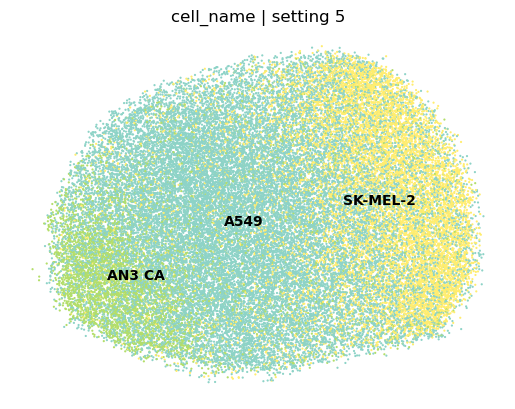

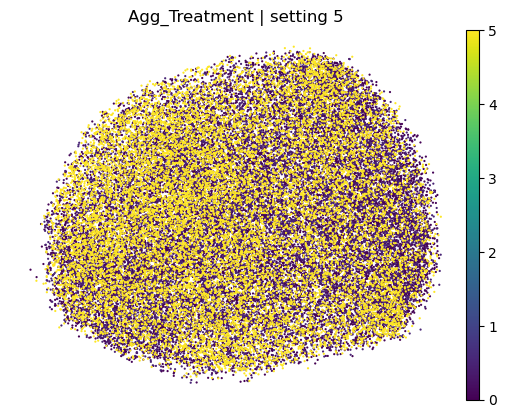

--- UMAP setting 6: {'n_neighbors': 15, 'min_dist': 0.1, 'spread': 2.0, 'metric': 'euclidean'} ---


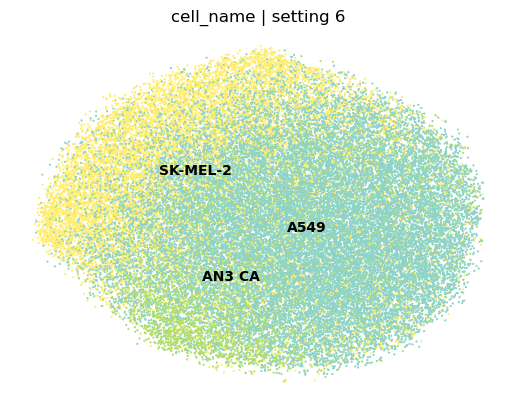

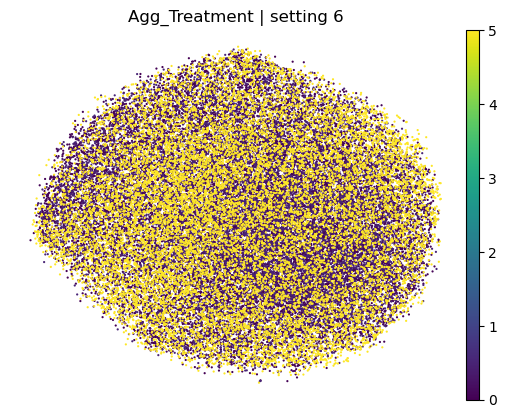

--- UMAP setting 7: {'n_neighbors': 30, 'min_dist': 0.2, 'spread': 1.5, 'metric': 'cosine'} ---


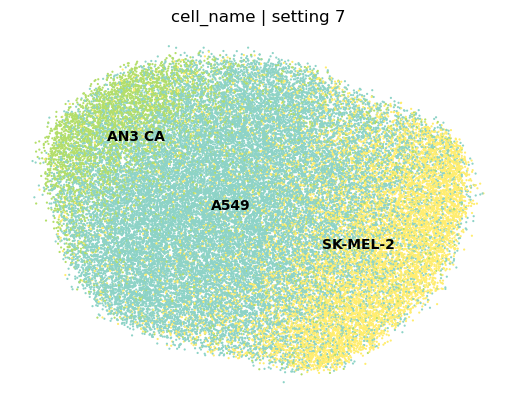

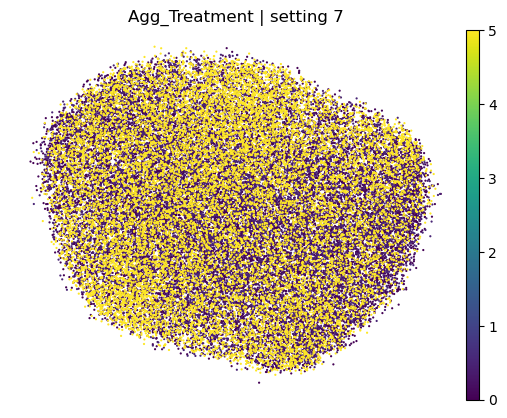

--- UMAP setting 8: {'n_neighbors': 30, 'min_dist': 0.2, 'spread': 1.5, 'metric': 'euclidean'} ---


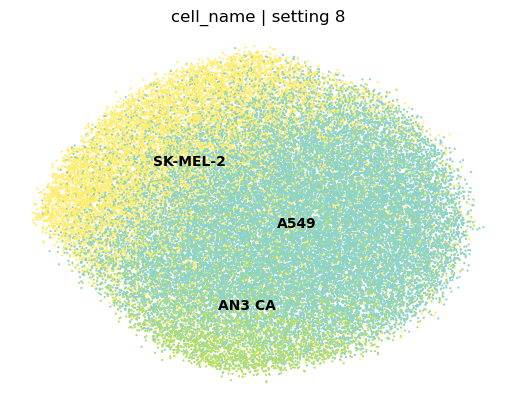

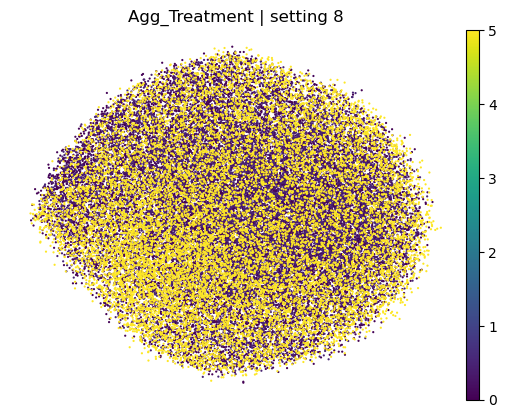

In [14]:
import scanpy as sc

# --- Common preprocessing ---
# Use latent space from your VAE
use_rep = "ZXs"

# Try multiple UMAP neighbor/min_dist settings
umap_settings = [
    {"n_neighbors": 10, "min_dist": 0.05, "spread": 5.0, "metric": "cosine"},
    {"n_neighbors": 10, "min_dist": 0.05, "spread": 5.0, "metric": "euclidean"},
    {"n_neighbors": 10, "min_dist": 0.05, "spread": 3.0, "metric": "cosine"},
    {"n_neighbors": 10, "min_dist": 0.05, "spread": 3.0, "metric": "euclidean"},
    {"n_neighbors": 15, "min_dist": 0.1,  "spread": 2.0, "metric": "cosine"},
    {"n_neighbors": 15, "min_dist": 0.1,  "spread": 2.0, "metric": "euclidean"},
    {"n_neighbors": 30, "min_dist": 0.2,  "spread": 1.5, "metric": "cosine"},
    {"n_neighbors": 30, "min_dist": 0.2,  "spread": 1.5, "metric": "euclidean"},
]

for i, params in enumerate(umap_settings, 1):
    print(f"--- UMAP setting {i}: {params} ---")
    sc.pp.neighbors(adata, use_rep=use_rep,
                    n_neighbors=params["n_neighbors"],
                    metric=params["metric"])
    sc.tl.umap(adata,
               min_dist=params["min_dist"],
               spread=params["spread"],
               random_state=0)
    
    # --- Plot for cell lines ---
    sc.pl.umap(
        adata,
        color="cell_name",
        frameon=False,
        palette="Set3",
        size=10,
        outline_color="gray",
        outline_width=0.5,
        legend_loc="on data",
        title=f"cell_name | setting {i}",
        show=True
    )

    # --- Plot for treatment ---
    sc.pl.umap(
        adata,
        color="dose",
        frameon=False,
        palette="Set3",
        size=10,
        outline_color="gray",
        outline_width=0.5,
        legend_loc="on data",
        title=f"Agg_Treatment | setting {i}",
        show=True
    )


## UMAP Settings

In [10]:
# UMAP settings
n_neighbors = 10 
min_dist = 0.05 
spread = 3.0
metric = "cosine"
size = 10

## Plot the Zx

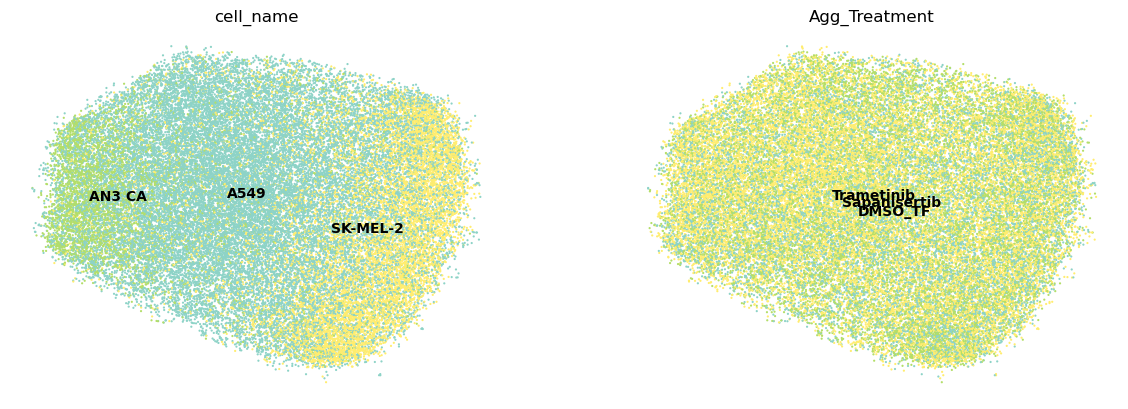

In [11]:
sc.pp.neighbors(adata, use_rep="ZXs",
                n_neighbors = n_neighbors,
                metric = metric)

sc.tl.umap(adata, min_dist=min_dist)
sc.pl.umap(
    adata,
    color=["cell_name", "Agg_Treatment"],
    frameon=False,
    palette="Set3",
    size=size,
    outline_color="gray",
    outline_width=0.5,
    legend_loc = "on data",
    color_map="Blues",
    vcenter=0.01,
    show=True
)

## Plot The Ztx

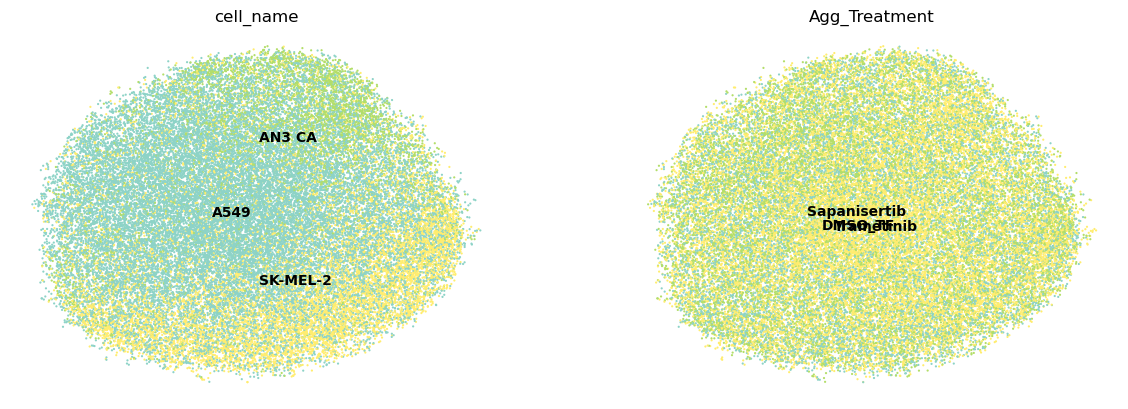

In [12]:
sc.pp.neighbors(adata, use_rep="ZXTs",
                n_neighbors = n_neighbors,
                metric = metric)

sc.tl.umap(adata, min_dist=min_dist)
sc.pl.umap(
    adata,
    color=["cell_name", "Agg_Treatment"],
    frameon=False,
    palette="Set3",
    size=size,
    outline_color="gray",
    outline_width=0.5,
    legend_loc = "on data",
    color_map="Blues",
    vcenter=0.01,
    show=True
)


## TESTS

In [15]:
adata = sc.read("/cluster/work/bewi/members/rquiles/experiments/datasets/test_3cell_lines_balanced.h5ad")

In [19]:
# Compute neighbors and UMAP
sc.pp.neighbors(adata, use_rep="ZXs", n_neighbors=15, metric="euclidean")
sc.tl.umap(adata, min_dist=0.3)

ax=None

fig = sc.pl.umap(
    adata,
    color="cell_name",
    frameon=False,
    palette="Set3",
    size=30,
    outline_color="gray",
    outline_width=0.5,
    legend_loc="on data",
    color_map="Blues",
    show=False,
    ax=ax,  # allows plotting into an existing axis
    return_fig=True,  # ensures we get the figure object
)

fig.savefig("/cluster/work/bewi/members/rquiles/experiments/alone")
plt.close()

In [22]:
# Compute neighbors and UMAP

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, rep in zip(axes, ["ZXs", "ZXTs", "ZTs"]):
    sc.pp.neighbors(adata, use_rep=rep, n_neighbors=15, metric="euclidean")
    sc.tl.umap(adata, min_dist=0.3)
    fig = sc.pl.umap(
        adata,
        color="cell_name",
        frameon=False,
        palette="Set3",
        size=30,
        outline_color="gray",
        outline_width=0.5,
        legend_loc="on data",
        color_map="Blues",
        show=False,
        ax=ax,  # allows plotting into an existing axis
        return_fig=False,  # ensures we get the figure object
)

plt.savefig("/cluster/work/bewi/members/rquiles/experiments/concat")
plt.close()

In [12]:
fig.savefig("/cluster/work/bewi/members/rquiles/experiments/alone")

## Plot Zt

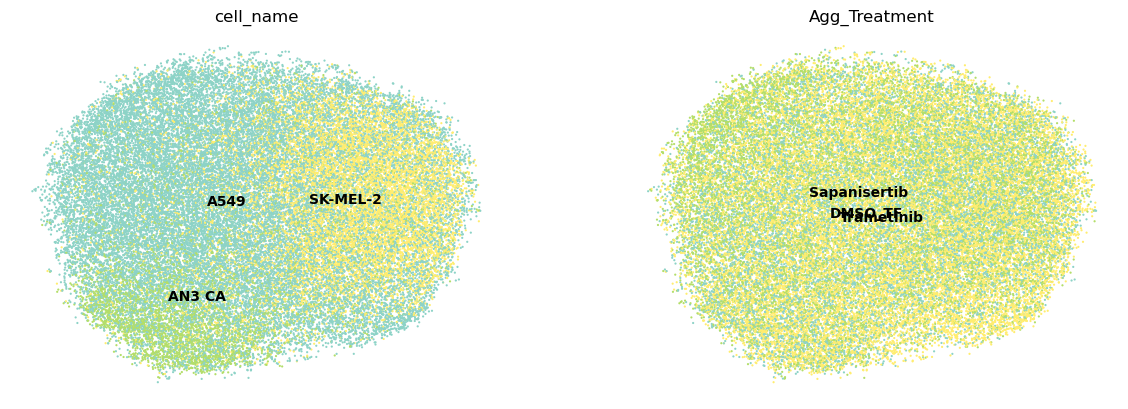

In [13]:
sc.pp.neighbors(adata, use_rep="ZTs",
                n_neighbors = n_neighbors,
                metric = metric)

sc.tl.umap(adata, min_dist=min_dist)
sc.pl.umap(
    adata,
    color=["cell_name", "Agg_Treatment"],
    frameon=False,
    palette="Set3",
    size=size,
    outline_color="gray",
    outline_width=0.5,
    legend_loc = "on data",
    color_map="Blues",
    vcenter=0.01,
    show=True
)

## Evaluation Metrics

## Clustering Results

In [181]:
## Leiden clustering with latent representations
sc.pp.neighbors(adata, use_rep="ZXs")
sc.tl.leiden(adata)

In [112]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

In [113]:
def change_cov_pert(row):
    cov_pert = row["cov_pert_name"].split("_")
    treatment = row["Agg_Treatment"]
    dose = row["dose"]
    cov_pert[-1] = treatment
    cov_pert.append(str(dose))
    return "_".join(cov_pert)

change_cov_pert(adata.obs.iloc[1])


'MCF7_rep2_HDAC_1.0'

In [114]:
adata.obs.cov_pert_name = adata.obs.apply(lambda row: change_cov_pert(row), axis=1)

## ZX clustering results

In [182]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.8863428628937162


In [183]:
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.8238444574513598


In [184]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.09829543937340746


In [185]:
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.05301747408077814


In [186]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.6511332989518566
0.31726414919247337


## ZT clustering results

In [187]:
sc.pp.neighbors(adata, use_rep="ZTs")
sc.tl.leiden(adata)

In [188]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.5619585830678413
0.1395229654570747


In [189]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.27583042876320196
0.06860050247808464


In [190]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.646582288990604
0.29361767026155716


## ZXT clustering results

In [191]:
sc.pp.neighbors(adata, use_rep="ZXTs")
sc.tl.leiden(adata)

In [192]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7923130132865274
0.5441595967472919


In [193]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.2253500405576085
0.0880559105845019


In [194]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7177526301183345
0.3721521537956975
